#### Imports and global Variables ####

In [1]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt     #pyplot is a collection of functions to make Python work like MATLAB
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import xarray as xr
import os
import math

#os.chdir('C:\\Users\\arthu\\OneDrive - Universität Graz\\Privat\\Bachelorarbeit\\Literatur, Daten\\data\\Roenfeld')
os.chdir('C:\\Users\\arthu\\Desktop\\Roenfeld')

borders = cfeature.NaturalEarthFeature( #cfeature draws Mapdata from a Database
    category='cultural',
    name='admin_0_countries',
    scale='10m',
    facecolor='none')

    #DS_temp1 = xr.open_dataset('INCA_2008_monmean_SPARTACUS.nc')
    #DS_orog1 = xr.open_dataset('INCA_orog_SPARTACUS.nc')
    #DS_temp2 = xr.open_dataset('SPARTACUS_2008_monmean.nc')

graz = (47.0667,15.4214) #lon,lat
vienna = (48.210033,16.363449)
innsbruck = (47.26266,11.39454)
klagenfurt = (46.636460,14.312225)
location_coordinates = list(enumerate([graz,vienna,innsbruck,klagenfurt]))
location_names = list(enumerate(["Graz","Wien","Innsbruck","Klagenfurt"]))

l1 = ["Jänner","Februar","März","April","Mai","Juni","Juli","August","September","Oktober","November","Dezember"]
month_names = list(enumerate(l1))

graphcnt = 0

DS_temp_incaonspart = xr.open_dataset('INCA_2008_monmean_SPARTACUS.nc')
DS_orog_spart = xr.open_dataset('INCA_orog_SPARTACUS.nc')
DS_temp_spart = xr.open_dataset('SPARTACUS_2008_monmean.nc')
DS_temp_inca = xr.open_dataset('INCA_2008_monmean.nc')
DS_orog_inca = xr.open_dataset('INCA_orog.nc')
#os.listdir()

#### Parameters for plotting and calculation
Change the values here:

In [2]:
#########################Calculation#####################################
area = 20   #specifies area around a certain 
            #point where the profile of the inversion will be plotted
    
month = 1   #specify a certain month:
            #[(0, 'Jänner'), (1, 'Februar'), (2, 'März'), 
            #(3, 'April'), (4, 'Mai'), (5, 'Juni'), 
            #(6, 'Juli'), (7, 'August'), (8, 'September'), 
            #(9, 'Oktober'), (10, 'November'), (11, 'Dezember')]
            
res = 100    #specify the resolution of the height profile in meters

location = 3  #(0, 'Graz'),(1,'Wien'),(2,'Innsbruck'),(3,'Klagenfurt')
#########################Plotting#######################################

#### Functions Part ####

2. Get the vertical average Temperature per 100m of a specified area around Indizes. (Author: Arthur Rönfeld, Dezember 2019)
3. Make Maps for visual comparision
(Author: Arthur Rönfeld, Jänner 2020)

In [3]:
def naive_fast(latvar,lonvar,coordtuple):
    '''
    Find closest point in a set of (lat,lon) points to specified point
    latvar - 2D latitude variable from an open netCDF dataset
    lonvar - 2D longitude variable from an open netCDF dataset
    lat0,lon0 - query point
    Returns iy,ix such that the square of the tunnel distance
    between (latval[it,ix],lonval[iy,ix]) and (lat0,lon0)
    is minimum.
    '''
    # Read latitude and longitude from file into numpy arrays
    lat0,lon0 = coordtuple
    latvals = latvar[:]
    lonvals = lonvar[:]
    ny,nx = latvals.shape
    dist_sq = (latvals-lat0)**2 + (lonvals-lon0)**2
    minindex_flattened = dist_sq.argmin()  # 1D index of min element
    minindex_flattened
    iy_min,ix_min = np.unravel_index(minindex_flattened, latvals.shape)
    return iy_min,ix_min

# Function takes 2D Arrays of Height and Temperature, Sorts them and returns a Dict 
# with keys = height means and values = temp means
# 
#
# Inputs of the function:
#
def get_tempprofile(DA_temp,DA_orog,iy,ix,area,resolution,month):
    h_mean=[]
    T_mean=[]   
    tmp_dict = dict()
    tmp_list = []
    x = 0
    res = resolution
    temperature = (np.array(DA_temp[month,(iy-area):(iy+area),(ix-area):(ix+area)]))
    height = (np.array(DA_orog[(iy-area):(iy+area),(ix-area):(ix+area)]))
    
    # Making a List out of X by Y Arrays (2-Dimensonal)
    for i in height:
        for j in i:
            h_mean.append(j)
    for k in temperature:
        for l in k:
            T_mean.append(l)
  
    #Sorting of the Values (lowest to highest)
    tmp_profile = list(zip(h_mean, T_mean))
    tmp_profile.sort(key=lambda tmp_profile: tmp_profile[0])

    # Deleting all 'nan' Entries
    for i,k in enumerate(tmp_profile):
        if np.isnan(k[1]):
            tmp_profile.remove(k)

    length = len(tmp_profile)
    #if np.isnan(tmp_profile[length-15][1])
    #breakpoint()
    tmp_profile = np.array(tmp_profile)
    
    for cnt,(m,n) in enumerate(tmp_profile):
        # eg. Smaller than 300m
        #print(m)
        # Again checking for 'nans' bc. somehow they persist in the first loop
        if np.isnan(n):
            pass
        elif (x) > m:
            #solange m im Bereich von x + res (Auflösung) liegen:
            tmp_list.append(n)
            if cnt == (length-1):
                mean_temp = sum(tmp_list)/len(tmp_list)
                tmp_dict.update({(x):mean_temp})
                tmp_list = []
                break
        else:
            # Occurs during first run
            if x == 0:
                x = int(m/res)*res + res
                tmp_list.append(n)
            elif m >= x:
                #speichern des Temperaturmittelwertes im tmp_dict
                if len(tmp_list)>0:
                    # look at 
                    mean_temp = sum(tmp_list)/len(tmp_list)
                    tmp_dict.update({(x):mean_temp})
                    tmp_list = []
                    #Temp-Wert für nächstes x-Intervall hinzufügen
                    tmp_list.append(n)
                    x = int(m/res)*res + res
                    if cnt == (length-1):
                        mean_temp = sum(tmp_list)/len(tmp_list)
                        tmp_dict.update({(x):mean_temp})
                        tmp_list = []
                        break
                #zu korrigieren: Wert wird fälschlicherweise beim nächsten 
                # Though the heighest Value gets lost...
                # Maybe change it later...
                            #to catch the last value in the tmp_profile array
                else:
                    break
    h_mean.clear()
    T_mean.clear()
    for v in tmp_dict.keys():
        h_mean.append(float(v))
    for w in tmp_dict.values():
        T_mean.append(float(w))
    return h_mean, T_mean, tmp_dict

def example_plot(DS,month_list,figure,borders,cmp): 
    
    global month_names
    lat = DS.coords["lat"]
    lon = DS.coords["lon"]
    
    divnorm = DivergingNorm(vmin=DS.min(skipna=True), vcenter=0, vmax=DS.max(skipna=True))
    
    #axcbar = figure.add_subplot(111,projection=ccrs.PlateCarree())
    
    
    for i,month in enumerate(month_list):
        
        layout = int(str(len(month_list))+"1"+str(i+1))
        tmp = DS.values[month]
        
        ax = figure.add_subplot(layout,projection=ccrs.PlateCarree())
        
        #pcm = ax.pcolormesh(lon, lat, tmp, cmap=cmp,norm=divnorm)
        
        ax.add_feature(borders, edgecolor='gray')
        ax.set_title(month_names[month][1])
        ax.text(-0.08, 0.55, 'Latitude[°]', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes)
        ax.text(0.5, -0.21, 'Longitude[°]', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes)
        
        g = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.1)
        g.xlabels_top = False
        g.ylabels_right = False
        ax = plt.contourf(lon, lat, tmp, 60,transform=ccrs.PlateCarree(),cmap=cmp,norm=divnorm)
        plt.colorbar(ScalarMappable(norm=divnorm,cmap=cmp),fraction=0.046, pad=0.04,label='Differenz [°C]')


    plt.subplots_adjust(hspace = 0.5)
    
    
    
def tempprof_plot(profs_inc,profs_spa,month_list,figure): 
    
    global month_names
    for i,month in enumerate(month_list):
        #layout = "4,"+"3,"+str(i+1)
        ax = figure.add_subplot(4,3,i+1)

        ax.set_title(month_names[month][1])
        
        ax.axes.get_yaxis().set_visible(False)
        if i in [0,3,6,9]:
            ax.set_ylabel('Höhe in Meter')
            ax.axes.get_yaxis().set_visible(True)
        if i in [9,10,11]:
            ax.set_xlabel('Temperatur in °C')
        

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
        #ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(250))
        
        plt.plot(profs_inc[i][1],profs_inc[i][0],profs_spa[i][1],profs_spa[i][0])
        ax.legend(('INCA','SPARTACUS'),fontsize=6)
    plt.subplots_adjust(hspace = 0.5,wspace=0.1)

#### Get locations in the Dataarrays of the Datasets ####
Show Values around lat&lon. One increment in Index corresponds to 1km in distance!
Due to the same Gridspacine, INCA and INCAonSPART should be the same!

In [4]:
####

iy_spart, ix_spart = naive_fast(DS_temp_spart.lat, DS_temp_spart.lon, location_coordinates[location][1])

iy_inca, ix_inca = naive_fast(DS_temp_inca.lat, DS_temp_inca.lon, location_coordinates[location][1])

iy_incaonspart, ix_incaonspart = naive_fast(DS_temp_incaonspart.lat, DS_temp_incaonspart.lon, location_coordinates[location][1])


'''
for x in range(0,10):    
    print('INCA Temperature at Index:',DS_temp_inca.T2M[month,iy_inca+x,ix_inca+x].values,'°C')
    print('INCAonSPART Temperature at Index:',DS_temp_incaonspart.tasmin[month,iy_incaonspart+x,ix_incaonspart+x].values,'°C')
    print('Height INCA at Index:',DS_orog_inca.orog[iy_inca+x,ix_inca+x].values,'Meters')
    print('Height INCAonSPART at Index:',DS_orog_spart.orog[iy_incaonspart+x,ix_incaonspart+x].values,'Meters')
'''

"\nfor x in range(0,10):    \n    print('INCA Temperature at Index:',DS_temp_inca.T2M[month,iy_inca+x,ix_inca+x].values,'°C')\n    print('INCAonSPART Temperature at Index:',DS_temp_incaonspart.tasmin[month,iy_incaonspart+x,ix_incaonspart+x].values,'°C')\n    print('Height INCA at Index:',DS_orog_inca.orog[iy_inca+x,ix_inca+x].values,'Meters')\n    print('Height INCAonSPART at Index:',DS_orog_spart.orog[iy_incaonspart+x,ix_incaonspart+x].values,'Meters')\n"

### Mittelwerte des Temperaturprofils
Mittelwert der 100m Höhenprofil entspricht
Möglichkeiten:
if zwischen 0 und 100 -> ary100m.append -> ary100m.mean


#### Klagenfurt

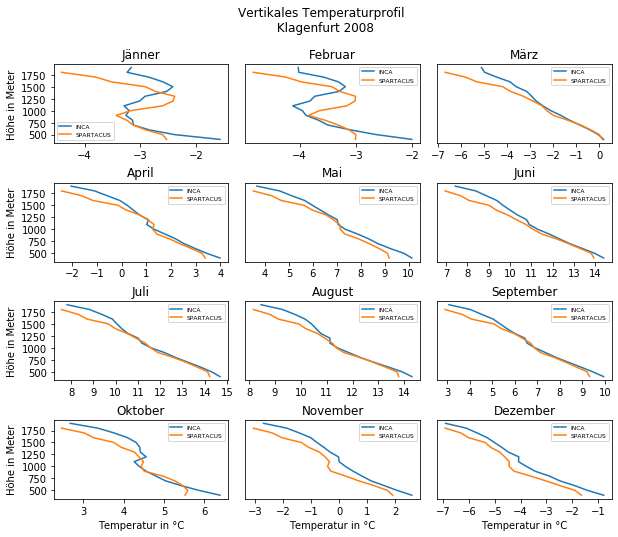

In [5]:
import matplotlib.ticker as ticker

location = 3 #klagenfurt
area = 20

iy_spart, ix_spart = naive_fast(DS_temp_spart.lat, DS_temp_spart.lon, location_coordinates[location][1])

iy_inca, ix_inca = naive_fast(DS_temp_inca.lat, DS_temp_inca.lon, location_coordinates[location][1])

months = [0,1,2,3,4,5,6,7,8,9,10,11]
profs_inca = []
profs_spart = []
for i in months:
    profs_inca.append(get_tempprofile(DS_temp_inca.T2M,DS_orog_inca.orog,iy_inca, ix_inca,area,res,i))
    profs_spart.append(get_tempprofile(DS_temp_spart.tasmin,DS_orog_spart.orog,iy_spart, ix_spart,area,res,i))

figprof = plt.figure(figsize= [10, 8])
tempprof_plot(profs_inca,profs_spart,months,figprof)
plt.suptitle("Vertikales Temperaturprofil \n "+location_names[location][1]+" 2008")
plt.savefig(fname="tmp_klagenfurt.pdf")
#ax.yaxis.set_minor_locator(ticker.MultipleLocator(50))
#INCA Blau
#SPARTACUS Gelb

#### Graz

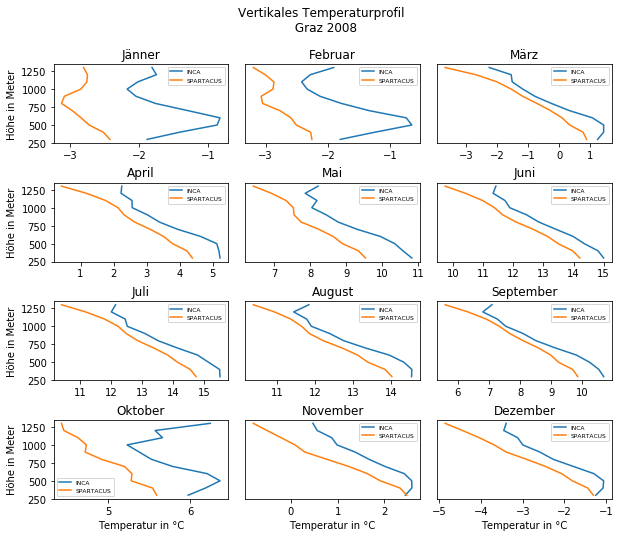

In [6]:
location = 0
area = 20

iy_spart, ix_spart = naive_fast(DS_temp_spart.lat, DS_temp_spart.lon, location_coordinates[location][1])
iy_inca, ix_inca = naive_fast(DS_temp_inca.lat, DS_temp_inca.lon, location_coordinates[location][1])

months = [0,1,2,3,4,5,6,7,8,9,10,11]
profs_inca = []
profs_spart = []
for i in months:
    profs_inca.append(get_tempprofile(DS_temp_inca.T2M,DS_orog_inca.orog,iy_inca, ix_inca,area,res,i))
    profs_spart.append(get_tempprofile(DS_temp_spart.tasmin,DS_orog_spart.orog,iy_spart, ix_spart,area,res,i))

figprof = plt.figure(figsize= [10, 8])
tempprof_plot(profs_inca,profs_spart,months,figprof)
plt.suptitle("Vertikales Temperaturprofil \n "+location_names[location][1]+" 2008")
plt.savefig(fname="tmp_graz.pdf")
#ax.yaxis.set_minor_locator(ticker.MultipleLocator(50))
#INCA Blau
#SPARTACUS Gelb

#### Wien

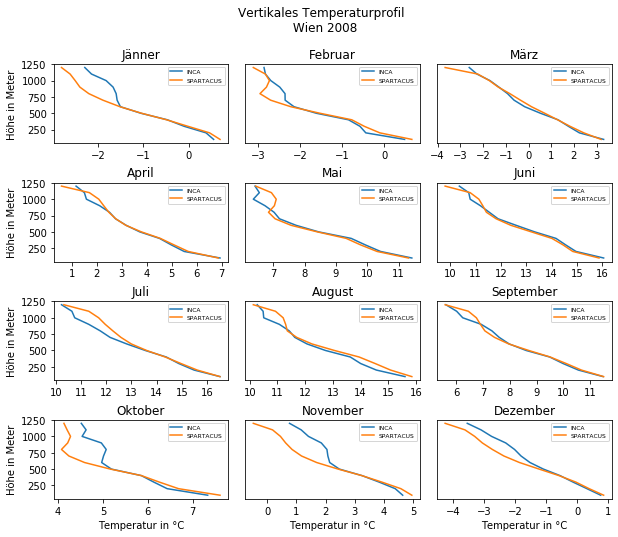

In [7]:
location = 1
area = 40

iy_spart, ix_spart = naive_fast(DS_temp_spart.lat, DS_temp_spart.lon, location_coordinates[location][1])
iy_inca, ix_inca = naive_fast(DS_temp_inca.lat, DS_temp_inca.lon, location_coordinates[location][1])

months = [0,1,2,3,4,5,6,7,8,9,10,11]
profs_inca = []
profs_spart = []
for i in months:
    profs_inca.append(get_tempprofile(DS_temp_inca.T2M,DS_orog_inca.orog,iy_inca, ix_inca,area,res,i))
    profs_spart.append(get_tempprofile(DS_temp_spart.tasmin,DS_orog_spart.orog,iy_spart, ix_spart,area,res,i))

figprof = plt.figure(figsize= [10, 8])
tempprof_plot(profs_inca,profs_spart,months,figprof)
plt.suptitle("Vertikales Temperaturprofil \n "+location_names[location][1]+" 2008")
plt.savefig(fname="tmp_wien.pdf")
#ax.yaxis.set_minor_locator(ticker.MultipleLocator(50))
#INCA Blau
#SPARTACUS Gelb

#### Innsbruck

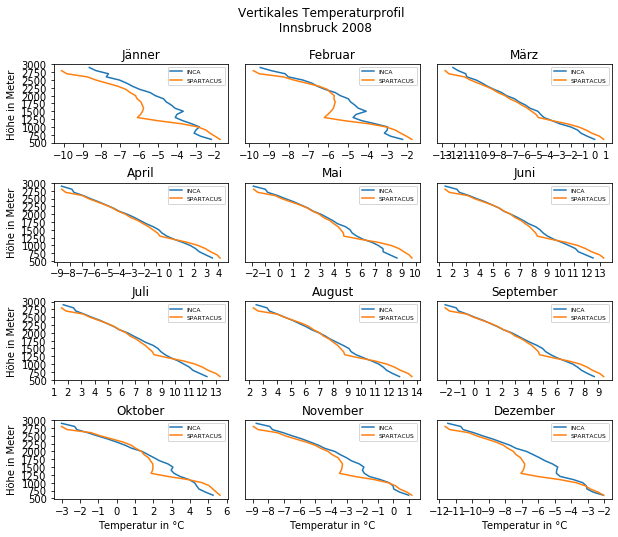

In [8]:
location = 2
area = 20

iy_spart, ix_spart = naive_fast(DS_temp_spart.lat, DS_temp_spart.lon, location_coordinates[location][1])
iy_inca, ix_inca = naive_fast(DS_temp_inca.lat, DS_temp_inca.lon, location_coordinates[location][1])

months = [0,1,2,3,4,5,6,7,8,9,10,11]
profs_inca = []
profs_spart = []
for i in months:
    profs_inca.append(get_tempprofile(DS_temp_inca.T2M,DS_orog_inca.orog,iy_inca, ix_inca,area,res,i))
    profs_spart.append(get_tempprofile(DS_temp_spart.tasmin,DS_orog_spart.orog,iy_spart, ix_spart,area,res,i))

figprof = plt.figure(figsize= [10, 8])
tempprof_plot(profs_inca,profs_spart,months,figprof)
plt.suptitle("Vertikales Temperaturprofil \n "+location_names[location][1]+" 2008")
plt.savefig(fname="tmp_innsbruck.pdf")
#ax.yaxis.set_minor_locator(ticker.MultipleLocator(50))
#INCA Blau
#SPARTACUS Gelb

### Creating the right colormap for the plot

In [9]:
from matplotlib.colors import ListedColormap, DivergingNorm
from matplotlib.cm import ScalarMappable
import matplotlib as mpl
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

DS_bias_temp = DS_temp_spart.tasmin-DS_temp_incaonspart.tasmin
lon,lat = DS_orog_spart.lon,DS_orog_spart.lat

top = cm.get_cmap('Oranges_r', 128)
bottom = cm.get_cmap('Blues', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')
newcmp = 'bwr'

### Plot DJF

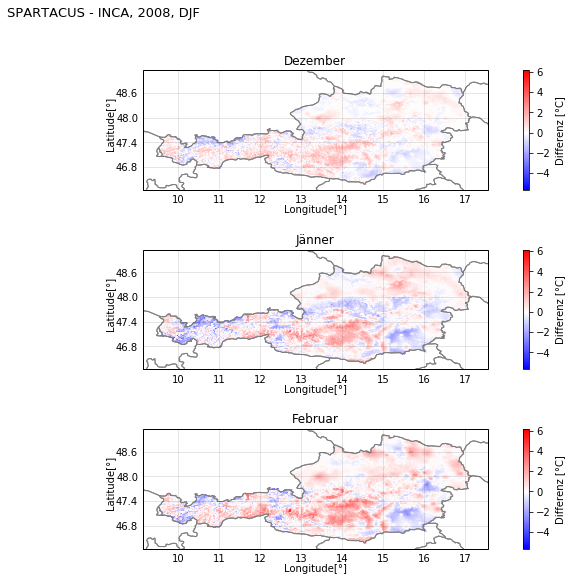

In [45]:
plt.close('all')
months = [11,0,1]

fig1 = plt.figure(figsize= [16, 8.8])
fig1.suptitle("SPARTACUS - INCA, 2008, DJF", fontsize=13)
example_plot(DS_bias_temp,months,fig1,borders,newcmp)
plt.savefig(fname="bias_djf.pdf")

### Plot MAM

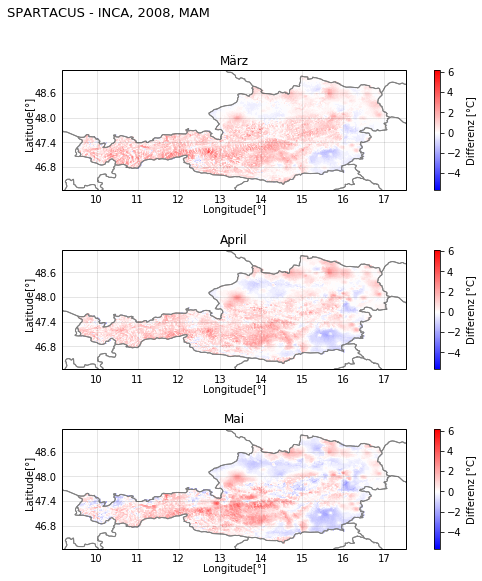

In [46]:
plt.close('all')
months = [2,3,4]

fig1 = plt.figure(figsize= [12.4, 8.8])
fig1.suptitle("SPARTACUS - INCA, 2008, MAM", fontsize=13)
example_plot(DS_bias_temp,months,fig1,borders,newcmp)
plt.savefig(fname="bias_mam.pdf")

### Plot JJA

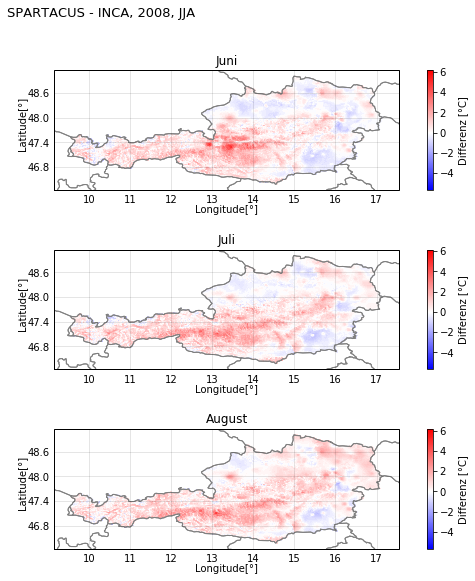

In [47]:
plt.close('all')
months = [5,6,7]

fig1 = plt.figure(figsize= [12.4, 8.8])
fig1.suptitle("SPARTACUS - INCA, 2008, JJA", fontsize=13)
example_plot(DS_bias_temp,months,fig1,borders,newcmp)
plt.savefig(fname="bias_jja.pdf")

### Plot SON

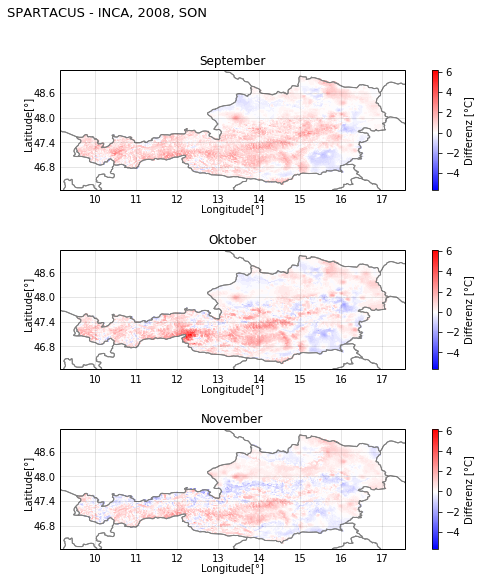

In [48]:
plt.close('all')
months = [8,9,10]

fig1 = plt.figure(figsize= [12.4, 8.8])
fig1.suptitle("SPARTACUS - INCA, 2008, SON", fontsize=13)
example_plot(DS_bias_temp,months,fig1,borders,newcmp)
plt.savefig(fname="bias_son.pdf")

#### Untersuchte Bereiche

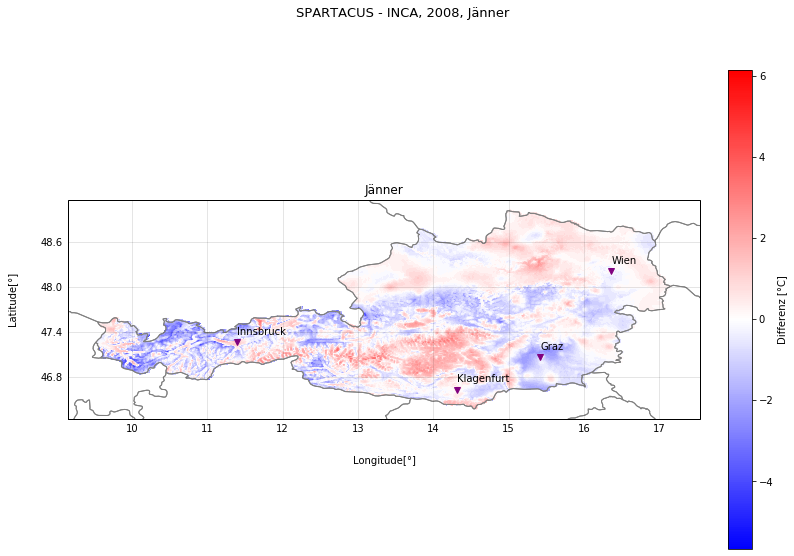

In [49]:
plt.close('all')
months = [0]

fig1 = plt.figure(figsize= [12.4, 8.8])
fig1.suptitle("SPARTACUS - INCA, 2008, Jänner", fontsize=13)
example_plot(DS_bias_temp,months,fig1,borders,newcmp)
for idx,i in enumerate(location_coordinates):
    plt.plot(i[1][1],i[1][0],
        color='purple', linewidth=1, marker='v')
    plt.text(i[1][1],i[1][0]+0.1,location_names[idx][1],
        color='black')
plt.savefig(fname="map_location.pdf")